In [1]:
# BASE
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd

# VISUALS
import matplotlib.pyplot as plt
import seaborn as sns

# MODELING
from hyperopt import hp, tpe, fmin, space_eval, Trials, STATUS_OK, STATUS_FAIL 
from sklearn.metrics import mean_squared_error

# TIME SERIES
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# DEEP LEARNING
import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import Adam
import keras_tuner as kt

RND_SEED = 1234

## 1. Prepare Data

### 1.1 Load Data

In [2]:
df = pd.read_csv('../data_mongo_mapreduce/daily_tweets.csv', index_col=0).sort_index()
date_range = list(sorted(df.index))
print('Tweet Data date range is from %s to %s' % (date_range[0], date_range[-1]))
df.sample(5)

Tweet Data date range is from 2020-02-11 to 2023-05-24


,count_pos_tweets,count_neg_tweets,ratio_pos_tweets,average_lenContent,average_replyCount,average_retweetCount,average_likeCount,average_quoteCount,average_followerCount,average_friendCount,...,average_neu,average_neg,average_compound,count_all,count_hasLinks,count_hasMedia,count_isRetweeted,count_isQuoted,count_hasHashtags,count_verified
2020-03-06,113.0,143.0,0.441406,184.605469,0.613281,2.429688,4.734375,0.253906,13198.480469,2306.441406,...,0.773918,0.098062,0.063131,256.0,100.0,62.0,0.0,48.0,190.0,0.0
2021-06-15,115.0,141.0,0.449219,192.300781,0.218750,0.632812,1.910156,0.050781,38525.597656,2839.289062,...,0.791219,0.084934,0.091997,256.0,130.0,79.0,0.0,25.0,196.0,0.0
2022-08-07,102.0,154.0,0.398438,199.554688,0.695312,2.390625,9.742188,0.101562,4815.457031,1817.140625,...,0.771645,0.105105,0.015093,256.0,107.0,71.0,0.0,31.0,209.0,0.0
2021-09-15,81.0,175.0,0.316406,190.136719,1.109375,1.617188,5.378906,0.425781,43223.187500,2508.042969,...,0.777383,0.120363,-0.064393,256.0,107.0,54.0,0.0,44.0,189.0,0.0
2022-09-08,114.0,142.0,0.445312,203.945312,2.746094,2.066406,10.015625,0.312500,15208.179688,2248.722656,...,0.767094,0.114590,0.027530,256.0,137.0,62.0,0.0,34.0,204.0,0.0


### 1.2 Split Data for Validation

In [3]:
# Split dataset for validating model performances
train_df = df[df.index < '2023-02-01']
test_df = df[df.index >= '2023-02-01']

train_df.tail(5)

,count_pos_tweets,count_neg_tweets,ratio_pos_tweets,average_lenContent,average_replyCount,average_retweetCount,average_likeCount,average_quoteCount,average_followerCount,average_friendCount,...,average_neu,average_neg,average_compound,count_all,count_hasLinks,count_hasMedia,count_isRetweeted,count_isQuoted,count_hasHashtags,count_verified
2023-01-27,93.0,163.0,0.363281,202.167969,0.359375,1.199219,4.363281,0.078125,8078.062500,2467.613281,...,0.774086,0.119176,-0.031293,256.0,122.0,76.0,0.0,35.0,203.0,0.0
2023-01-28,92.0,164.0,0.359375,206.445312,2.578125,2.914062,9.195312,0.203125,40377.000000,3021.480469,...,0.763203,0.121031,-0.040393,256.0,88.0,81.0,0.0,40.0,206.0,0.0
2023-01-29,91.0,165.0,0.355469,201.675781,0.640625,0.972656,3.617188,0.054688,5670.730469,2750.324219,...,0.754707,0.136195,-0.064421,256.0,113.0,60.0,0.0,35.0,211.0,0.0
2023-01-30,78.0,178.0,0.304688,201.343750,0.949219,5.066406,14.523438,0.339844,54627.574219,4902.285156,...,0.776246,0.130523,-0.084532,256.0,133.0,72.0,0.0,38.0,201.0,0.0
2023-01-31,75.0,181.0,0.292969,196.558594,0.566406,1.917969,5.636719,0.160156,10413.304688,2195.242188,...,0.766746,0.128539,-0.092446,256.0,114.0,73.0,0.0,35.0,204.0,0.0


### 1.3 Convert to scaled time series

In [4]:
# Create time series data frame for compound sentiment
# Scale [-1,1] compound polarity scores to [0,100]
#   Unsclaed -1 and scaled 0 are negative
#   Unscaled 0 and scaled 50 are neutral
#   Unscaled 1 and scaled 100 are positive
ts_scale = lambda ts: (1 + ts) * 50
ts_unscale = lambda ts: (ts / 50) - 1
full = ts_scale(df['average_compound'])
train = ts_scale(train_df['average_compound'])
test = ts_scale(test_df['average_compound'])
full_timestamps = np.array([[datetime.timestamp(datetime.strptime(d, '%Y-%m-%d'))] for d in full.index.values])
train_timestamps = np.array([[datetime.timestamp(datetime.strptime(d, '%Y-%m-%d'))] for d in train.index.values])
test_timestamps = np.array([[datetime.timestamp(datetime.strptime(d, '%Y-%m-%d'))] for d in test.index.values])
full.describe()

count    1199.000000
mean       51.372565
std         3.285955
min        40.978066
25%        49.358096
50%        51.384824
75%        53.552090
max        69.885273
Name: average_compound, dtype: float64

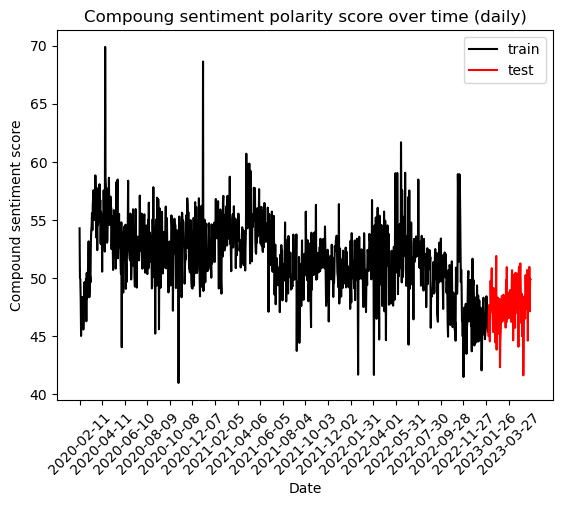

In [5]:
# Show time series over time
plt.plot(train, color='black', label='train')
plt.plot(test, color='red', label='test')
plt.ylabel('Compound sentiment score')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Compoung sentiment polarity score over time (daily)')
plt.show()

## 2. Hyperparameter Optimization for Models

In [6]:
# Create kwargs from params
def params_to_kwargs(params):
    named_params = {
        'order': (params['order_0'], params['order_1'], params['order_2']),
    }
    if 'seaosal_0' in params:
        named_params['seasonal_order'] = (params['seaosal_0'], params['seaosal_1'], params['seaosal_2'],
                                          params['seaosal_3'] + 2)
    for p in ['trend', 'measurement_error', 'time_varying_regression', 'mle_regression', 'simple_differencing',
              'enforce_stationarity', 'enforce_invertibility', 'hamilton_representation', 'concentrate_scale',
              'use_exact_diffuse', 'missing']:
        if p in params:
            named_params[p] = params[p]
    return named_params

# Hyperparameter Optimization function creater for given model type
def create_test_params(model_type, return_pred_values=False):
    # Creates the model, trains on train data and returns RMSE on test data
    # Returns predicted values if return_pred_values is True
    def test_params(params):
        # Create local train and test data, and convert to datetime index
        global train, test
        local_train = train.copy()
        local_train.index = pd.DatetimeIndex(local_train.index.values).to_period('D')
        local_test = test.copy()
        local_test.index = pd.DatetimeIndex(local_test.index.values).to_period('D')
        # Create kwargs from params
        named_params = params_to_kwargs(params)
        # Some parameters are not compatible with each other, if model fails return very high error
        try:
            model = model_type(local_train, **named_params).fit()
        except Exception as e:
            return {'loss': 99999999, 'status': STATUS_FAIL}
        # Forecast test dates
        pred_df = model.get_forecast(len(local_test.index)).conf_int(alpha=params['conf_alpha'])
        pred = model.predict(start=pred_df.index[0], end=pred_df.index[-1])
        pred.index = test.index
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(np.nan_to_num(test.values), np.nan_to_num(pred.values)))
        # Return pred values with flag, otherwise return loss
        if return_pred_values:
            return rmse, pred.values
        else:
            return {'loss': rmse, 'status': STATUS_OK}
    return test_params

In [7]:
# RMSE is not supported loss function in Tensorflow
# Defines RMSE loss with tensorflow functions
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Hyperparameter Optimization function creater for given model type
def create_model_builder(model_type):
    # Creates the model for given hyper parameters
    def model_builder(hyper_params):
        model = Sequential()
        model.add(layers.Input(shape=(1, 1)))

        # Tune the number of layers
        num_layers = hyper_params.Int('num_layers', min_value=1, max_value=3, step=1)

        # Tune the number of units in the layers
        num_layer_units = [
            hyper_params.Int('units1', min_value=16, max_value=256, step=16),
            hyper_params.Int('units2', min_value=16, max_value=256, step=16),
            hyper_params.Int('units3', min_value=32, max_value=512, step=32),
        ]
        
        # Layer types
        layer_models = [model_type for _ in range(num_layers)]
        if model_type == 'mixed':
            layer_models = []
            for i in range(num_layers):
                layer_models.append(hyper_params.Choice('layer_%d_model' % (i+1), values=['LSTM', 'GRU', 'RNN']))

        # Optimize kwargs
        params = {
            'activation': hyper_params.Choice('activation', values=['linear', 'tanh', 'sigmoid']),
            'use_bias': hyper_params.Boolean('use_bias', default=True),
            'kernel_initializer': hyper_params.Choice('kernel_initializer', values=['glorot_uniform', 'orthogonal', 'zeros']),
            'recurrent_initializer': hyper_params.Choice('recurrent_initializer', values=['glorot_uniform', 'orthogonal', 'zeros']),
            'bias_initializer': hyper_params.Choice('bias_initializer', values=['glorot_uniform', 'orthogonal', 'zeros']),
            'dropout': hyper_params.Float('dropout', min_value=0.0, max_value=0.3, step=0.02),
        }
        if not params['use_bias']:
            del params['bias_initializer']
        
        # Add layers
        for i, m in enumerate(layer_models):
            if m == 'LSTM':
                model.add(layers.LSTM(num_layer_units[i], return_sequences=True, **params))
            elif m == 'GRU':
                model.add(layers.GRU(num_layer_units[i], return_sequences=True, **params))
            elif m == 'RNN':
                model.add(layers.SimpleRNN(num_layer_units[i], return_sequences=True, **params))

        # Add Output layer
        model.add(layers.Dense(1))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hyper_params.Choice('learning_rate', values=[0.25, 0.1, 0.05, 0.01, 0.001, 0.0001])
        adam_optimizer = Adam(learning_rate=hp_learning_rate)

        # Compile model
        model.compile(loss=root_mean_squared_error, optimizer=adam_optimizer,
                      metrics=['log_cosh', 'mean_absolute_error', 'mean_squared_error', 'binary_crossentropy'])

        return model
    return model_builder

In [8]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

log_dir = "tf_logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

%tensorboard --logdir tf_logs/fit --host localhost

### 2.1 Autoregressive Moving Average (ARMA)

In [9]:
# Optimize ARMA
arma_param_space = {
    'order_0': hp.randint('order_0', 5),
    'order_1': hp.randint('order_1', 5),
    'order_2': hp.randint('order_2', 5),
    'trend': hp.choice('trend', [None, 'n', 'c', 't', 'ct']),
    'measurement_error': hp.choice('measurement_error', [False, True]),
    'time_varying_regression': hp.choice('time_varying_regression', [False, True]),
    'mle_regression': hp.choice('mle_regression', [False, True]),
    'simple_differencing': hp.choice('simple_differencing', [False, True]),
    'enforce_stationarity': hp.choice('enforce_stationarity', [False, True]),
    'enforce_invertibility': hp.choice('enforce_invertibility', [False, True]),
    'hamilton_representation': hp.choice('hamilton_representation', [False, True]),
    'concentrate_scale': hp.choice('concentrate_scale', [False, True]),
    'use_exact_diffuse': hp.choice('use_exact_diffuse', [False, True]),
    'conf_alpha': hp.uniform('conf_alpha', 0.0, 1.0),
}
arma_trials = Trials()
best_arma_params = fmin(create_test_params(SARIMAX), arma_param_space, algo=tpe.suggest, max_evals=128,
                        trials=arma_trials, rstate=np.random.default_rng(RND_SEED))
best_arma_params = space_eval(arma_param_space, best_arma_params)
arma_loss = [trial['loss'] for trial in arma_trials.results if trial['status'] == STATUS_OK]
print(best_arma_params)

  0%|                                                                          | 0/128 [00:00<?, ?trial/s, best loss=?]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



  2%|█▏                                               | 3/128 [00:02<01:54,  1.09trial/s, best loss: 7.654394254643309]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  5%|██▎                                              | 6/128 [00:04<01:31,  1.33trial/s, best loss: 2.501703313000267]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 14%|██████▊                                         | 18/128 [00:10<00:51,  2.14trial/s, best loss: 2.501703313000267]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 22%|██████████▌                                     | 28/128 [00:14<00:41,  2.41trial/s, best loss: 2.501703313000267]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 23%|███████████▎                                    | 30/128 [00:15<00:47,  2.07trial/s, best loss: 2.482412701727234]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 24%|███████████▋                                    | 31/128 [00:16<01:02,  1.55trial/s, best loss: 2.482412701727234]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 26%|████████████▍                                   | 33/128 [00:20<01:44,  1.10s/trial, best loss: 2.482412701727234]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 29%|█████████████▉                                  | 37/128 [00:24<01:40,  1.10s/trial, best loss: 2.463066566544017]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 30%|██████████████▋                                 | 39/128 [00:27<02:14,  1.51s/trial, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 32%|███████████████▍                                | 41/128 [00:30<02:03,  1.42s/trial, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 37%|█████████████████▋                              | 47/128 [00:33<01:02,  1.30trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 38%|██████████████████                              | 48/128 [00:34<01:07,  1.18trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 42%|████████████████████▎                           | 54/128 [00:40<01:04,  1.15trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 44%|█████████████████████                           | 56/128 [00:41<01:02,  1.15trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 48%|███████████████████████▎                        | 62/128 [00:43<00:31,  2.11trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 51%|████████████████████████▍                       | 65/128 [00:47<01:00,  1.04trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 58%|███████████████████████████▊                    | 74/128 [00:57<01:03,  1.17s/trial, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 59%|████████████████████████████▏                   | 75/128 [00:58<01:09,  1.31s/trial, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 59%|████████████████████████████▌                   | 76/128 [00:59<00:55,  1.07s/trial, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 61%|█████████████████████████████▎                  | 78/128 [01:00<00:47,  1.05trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 65%|███████████████████████████████▏                | 83/128 [01:02<00:24,  1.86trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 66%|███████████████████████████████▌                | 84/128 [01:03<00:27,  1.60trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 67%|████████████████████████████████▎               | 86/128 [01:06<00:41,  1.01trial/s, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 70%|█████████████████████████████████▍              | 89/128 [01:09<00:43,  1.11s/trial, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 70%|█████████████████████████████████▊              | 90/128 [01:12<00:54,  1.42s/trial, best loss: 2.310354137816852]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 73%|██████████████████████████████████▉             | 93/128 [01:14<00:31,  1.11trial/s, best loss: 2.285613040457159]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 74%|███████████████████████████████████▋            | 95/128 [01:17<00:41,  1.27s/trial, best loss: 2.285613040457159]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 76%|████████████████████████████████████▍           | 97/128 [01:18<00:33,  1.08s/trial, best loss: 2.285613040457159]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 77%|████████████████████████████████████▊           | 98/128 [01:20<00:36,  1.22s/trial, best loss: 2.285613040457159]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 80%|█████████████████████████████████████         | 103/128 [01:23<00:15,  1.61trial/s, best loss: 1.9488069338733198]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 82%|█████████████████████████████████████▋        | 105/128 [01:26<00:23,  1.01s/trial, best loss: 1.9488069338733198]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 83%|██████████████████████████████████████        | 106/128 [01:27<00:21,  1.04trial/s, best loss: 1.9488069338733198]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 84%|██████████████████████████████████████▍       | 107/128 [01:27<00:19,  1.07trial/s, best loss: 1.9488069338733198]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 84%|██████████████████████████████████████▊       | 108/128 [01:29<00:21,  1.08s/trial, best loss: 1.9488069338733198]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 85%|███████████████████████████████████████▏      | 109/128 [01:30<00:19,  1.01s/trial, best loss: 1.9488069338733198]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 86%|███████████████████████████████████████▌      | 110/128 [01:30<00:15,  1.16trial/s, best loss: 1.9488056770506839]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 87%|███████████████████████████████████████▉      | 111/128 [01:32<00:18,  1.08s/trial, best loss: 1.9488056770506839]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 92%|███████████████████████████████████████████▎   | 118/128 [01:36<00:06,  1.59trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 93%|███████████████████████████████████████████▋   | 119/128 [01:37<00:06,  1.30trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 95%|████████████████████████████████████████████▍  | 121/128 [01:39<00:05,  1.29trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 95%|████████████████████████████████████████████▊  | 122/128 [01:40<00:04,  1.37trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 96%|█████████████████████████████████████████████▏ | 123/128 [01:40<00:03,  1.39trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 97%|█████████████████████████████████████████████▌ | 124/128 [01:42<00:03,  1.02trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 98%|█████████████████████████████████████████████▉ | 125/128 [01:43<00:02,  1.11trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 98%|██████████████████████████████████████████████▎| 126/128 [01:43<00:01,  1.19trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 99%|██████████████████████████████████████████████▋| 127/128 [01:44<00:00,  1.25trial/s, best loss: 1.935057847042902]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



100%|███████████████████████████████████████████████| 128/128 [01:45<00:00,  1.22trial/s, best loss: 1.935057847042902]
{'concentrate_scale': True, 'conf_alpha': 0.20396526654459302, 'enforce_invertibility': True, 'enforce_stationarity': False, 'hamilton_representation': True, 'measurement_error': True, 'mle_regression': False, 'order_0': 1, 'order_1': 0, 'order_2': 1, 'simple_differencing': True, 'time_varying_regression': True, 'trend': 't', 'use_exact_diffuse': False}


### 2.2 Autoregressive Integrated Moving Average (ARIMA)

In [10]:
# Optimize ARIMA
arima_param_space = {
    'order_0': hp.randint('order_0', 5),
    'order_1': hp.randint('order_1', 5),
    'order_2': hp.randint('order_2', 5),
    'trend': hp.choice('trend', [None, 'n', 'c', 't', 'ct']),
    'enforce_stationarity': hp.choice('enforce_stationarity', [False, True]),
    'enforce_invertibility': hp.choice('enforce_invertibility', [False, True]),
    'concentrate_scale': hp.choice('concentrate_scale', [False, True]),
    'missing': hp.choice('missing', [None, 'drop', 'raise']),
    'conf_alpha': hp.uniform('conf_alpha', 0.0, 1.0),
}
arima_trials = Trials()
best_arima_params = fmin(create_test_params(ARIMA), arima_param_space, algo=tpe.suggest, max_evals=128,
                         trials=arima_trials, rstate=np.random.default_rng(RND_SEED))
best_arima_params = space_eval(arima_param_space, best_arima_params)
arima_loss = [trial['loss'] for trial in arima_trials.results if trial['status'] == STATUS_OK]
print(best_arima_params)

  4%|█▉                                               | 5/128 [00:03<01:22,  1.49trial/s, best loss: 2.399112452089953]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  6%|███                                              | 8/128 [00:06<01:59,  1.00trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  9%|████▏                                           | 11/128 [00:07<01:22,  1.42trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 14%|██████▊                                         | 18/128 [00:12<01:19,  1.38trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 16%|███████▌                                        | 20/128 [00:16<02:04,  1.16s/trial, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 16%|███████▉                                        | 21/128 [00:17<02:15,  1.27s/trial, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 17%|████████▎                                       | 22/128 [00:19<02:23,  1.35s/trial, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 18%|████████▋                                       | 23/128 [00:20<02:25,  1.39s/trial, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 20%|█████████▊                                      | 26/128 [00:22<01:34,  1.07trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 21%|██████████▏                                     | 27/128 [00:24<01:47,  1.06s/trial, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 23%|███████████▎                                    | 30/128 [00:25<01:19,  1.23trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 27%|████████████▊                                   | 34/128 [00:26<00:38,  2.47trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 34%|████████████████▏                               | 43/128 [00:29<00:19,  4.34trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 38%|██████████████████                              | 48/128 [00:31<00:34,  2.32trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 39%|██████████████████▊                             | 50/128 [00:33<01:00,  1.30trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 42%|████████████████████▎                           | 54/128 [00:35<00:38,  1.94trial/s, best loss: 2.059484546809178]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 70%|█████████████████████████████████▊              | 90/128 [00:56<00:18,  2.06trial/s, best loss: 2.000520504622128]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 88%|█████████████████████████████████████████▍     | 113/128 [01:08<00:07,  1.94trial/s, best loss: 2.000520504622128]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 91%|██████████████████████████████████████████▌    | 116/128 [01:11<00:09,  1.28trial/s, best loss: 2.000520504622128]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 92%|███████████████████████████████████████████▎   | 118/128 [01:12<00:07,  1.39trial/s, best loss: 2.000520504622128]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 95%|████████████████████████████████████████████▍  | 121/128 [01:14<00:05,  1.29trial/s, best loss: 2.000520504622128]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



100%|███████████████████████████████████████████████| 128/128 [01:18<00:00,  1.64trial/s, best loss: 2.000520504622128]
{'concentrate_scale': False, 'conf_alpha': 0.7690228482008833, 'enforce_invertibility': False, 'enforce_stationarity': False, 'missing': 'drop', 'order_0': 1, 'order_1': 0, 'order_2': 2, 'trend': 'ct'}


### 2.3 Seasonal ARIMA (SARIMA)

In [11]:
# Optimize SARIMA
sarima_param_space = {
    'order_0': hp.randint('order_0', 5),
    'order_1': hp.randint('order_1', 5),
    'order_2': hp.randint('order_2', 5),
    'seasonal_0': hp.randint('seasonal_0', 5),
    'seasonal_1': hp.randint('seasonal_1', 5),
    'seasonal_2': hp.randint('seasonal_2', 5),
    'seasonal_3': hp.randint('seasonal_3', 5),
    'trend': hp.choice('trend', [None, 'n', 'c', 't', 'ct']),
    'measurement_error': hp.choice('measurement_error', [False, True]),
    'time_varying_regression': hp.choice('time_varying_regression', [False, True]),
    'mle_regression': hp.choice('mle_regression', [False, True]),
    'simple_differencing': hp.choice('simple_differencing', [False, True]),
    'enforce_stationarity': hp.choice('enforce_stationarity', [False, True]),
    'enforce_invertibility': hp.choice('enforce_invertibility', [False, True]),
    'hamilton_representation': hp.choice('hamilton_representation', [False, True]),
    'concentrate_scale': hp.choice('concentrate_scale', [False, True]),
    'use_exact_diffuse': hp.choice('use_exact_diffuse', [False, True]),
    'conf_alpha': hp.uniform('conf_alpha', 0.0, 1.0),
}
sarima_trials = Trials()
best_sarima_params = fmin(create_test_params(SARIMAX), sarima_param_space, algo=tpe.suggest, max_evals=256,
                          trials=sarima_trials, rstate=np.random.default_rng(RND_SEED))
best_sarima_params = space_eval(sarima_param_space, best_sarima_params)
sarima_loss = [trial['loss'] for trial in sarima_trials.results if trial['status'] == STATUS_OK]
print(best_sarima_params)

  1%|▌                                               | 3/256 [00:01<02:17,  1.84trial/s, best loss: 47.814198374981274]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  2%|█▏                                               | 6/256 [00:02<01:58,  2.11trial/s, best loss: 47.80533565067813]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  4%|█▉                                              | 10/256 [00:03<01:24,  2.92trial/s, best loss: 47.80429073014452]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



  5%|██▋                                             | 14/256 [00:06<02:08,  1.89trial/s, best loss: 47.80429073014452]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



  6%|██▊                                            | 15/256 [00:07<02:39,  1.51trial/s, best loss: 3.8304258209911586]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  6%|███                                             | 16/256 [00:08<03:05,  1.30trial/s, best loss: 2.502946418068033]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  7%|███                                            | 17/256 [00:09<02:50,  1.40trial/s, best loss: 2.1872180118205584]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  8%|███▊                                           | 21/256 [00:11<02:12,  1.77trial/s, best loss: 2.1872180118205584]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  9%|████▏                                          | 23/256 [00:12<02:25,  1.60trial/s, best loss: 2.1872180118205584]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 12%|█████▌                                         | 30/256 [00:18<02:15,  1.66trial/s, best loss: 2.1872180118205584]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 12%|█████▉                                         | 32/256 [00:21<03:17,  1.13trial/s, best loss: 2.1872180118205584]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 14%|██████▍                                        | 35/256 [00:22<02:08,  1.72trial/s, best loss: 2.1872180118205584]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 15%|██████▉                                        | 38/256 [00:23<01:29,  2.43trial/s, best loss: 2.1872180118205584]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 16%|███████▎                                       | 40/256 [00:25<02:48,  1.28trial/s, best loss: 2.1872180118205584]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 17%|████████                                       | 44/256 [00:27<01:56,  1.82trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 18%|████████▍                                      | 46/256 [00:28<01:44,  2.02trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 18%|████████▋                                      | 47/256 [00:29<02:31,  1.38trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 19%|████████▊                                      | 48/256 [00:30<02:27,  1.41trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 20%|█████████▎                                     | 51/256 [00:32<03:03,  1.12trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 25%|███████████▊                                   | 64/256 [00:45<03:04,  1.04trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 28%|█████████████                                  | 71/256 [00:47<01:09,  2.67trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 28%|█████████████▏                                 | 72/256 [00:49<02:28,  1.24trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 29%|█████████████▌                                 | 74/256 [00:50<02:12,  1.38trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 29%|█████████████▊                                 | 75/256 [00:51<02:38,  1.14trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 32%|███████████████▏                               | 83/256 [00:58<01:40,  1.73trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 33%|███████████████▍                               | 84/256 [00:58<01:39,  1.72trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 33%|███████████████▌                               | 85/256 [01:01<03:07,  1.09s/trial, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 36%|████████████████▉                              | 92/256 [01:04<01:38,  1.67trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 38%|█████████████████▋                             | 96/256 [01:06<01:27,  1.83trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 38%|█████████████████▉                             | 98/256 [01:09<02:23,  1.10trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 39%|██████████████████▏                           | 101/256 [01:11<01:51,  1.39trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 41%|██████████████████▋                           | 104/256 [01:13<01:47,  1.42trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 41%|███████████████████                           | 106/256 [01:15<01:52,  1.33trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 44%|████████████████████▎                         | 113/256 [01:19<01:30,  1.57trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 45%|████████████████████▋                         | 115/256 [01:22<02:18,  1.01trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 46%|█████████████████████▏                        | 118/256 [01:23<01:34,  1.47trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 48%|█████████████████████▉                        | 122/256 [01:25<01:07,  1.97trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 48%|██████████████████████                        | 123/256 [01:27<01:26,  1.54trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 50%|███████████████████████                       | 128/256 [01:30<01:26,  1.48trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 52%|███████████████████████▋                      | 132/256 [01:33<01:13,  1.70trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 52%|████████████████████████                      | 134/256 [01:35<01:34,  1.29trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 54%|████████████████████████▊                     | 138/256 [01:38<01:17,  1.53trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 54%|████████████████████████▉                     | 139/256 [01:40<01:43,  1.14trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 57%|██████████████████████████                    | 145/256 [01:46<01:43,  1.07trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 60%|███████████████████████████▋                  | 154/256 [01:49<00:45,  2.23trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 61%|███████████████████████████▊                  | 155/256 [01:50<00:51,  1.97trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 61%|████████████████████████████                  | 156/256 [01:51<00:55,  1.80trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 61%|████████████████████████████▏                 | 157/256 [01:51<00:57,  1.72trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 62%|████████████████████████████▍                 | 158/256 [01:52<00:58,  1.67trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 63%|████████████████████████████▉                 | 161/256 [01:55<01:27,  1.08trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 64%|█████████████████████████████▎                | 163/256 [01:57<01:25,  1.08trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 64%|█████████████████████████████▋                | 165/256 [01:57<00:52,  1.73trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 65%|██████████████████████████████                | 167/256 [01:59<01:02,  1.44trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 66%|██████████████████████████████▌               | 170/256 [02:00<00:47,  1.79trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 68%|███████████████████████████████               | 173/256 [02:03<01:11,  1.16trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 68%|███████████████████████████████▎              | 174/256 [02:03<00:57,  1.43trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 69%|███████████████████████████████▋              | 176/256 [02:05<00:51,  1.56trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 70%|███████████████████████████████▉              | 178/256 [02:06<00:49,  1.59trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 71%|████████████████████████████████▋             | 182/256 [02:07<00:30,  2.46trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 72%|█████████████████████████████████             | 184/256 [02:08<00:27,  2.61trial/s, best loss: 1.9383494704655224]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 79%|████████████████████████████████████▍         | 203/256 [02:16<00:20,  2.54trial/s, best loss: 1.9337349277431595]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 82%|█████████████████████████████████████▋        | 210/256 [02:19<00:20,  2.25trial/s, best loss: 1.9337349277431595]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 82%|█████████████████████████████████████▉        | 211/256 [02:19<00:22,  1.97trial/s, best loss: 1.9337349277431595]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 86%|███████████████████████████████████████▎      | 219/256 [02:21<00:11,  3.22trial/s, best loss: 1.9337349277431595]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 87%|████████████████████████████████████████      | 223/256 [02:23<00:12,  2.65trial/s, best loss: 1.9337349277431595]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 91%|█████████████████████████████████████████▋    | 232/256 [02:27<00:10,  2.29trial/s, best loss: 1.9337349277431595]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



 93%|██████████████████████████████████████████▉   | 239/256 [02:30<00:06,  2.45trial/s, best loss: 1.9337349277431595]

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



100%|██████████████████████████████████████████████| 256/256 [02:34<00:00,  1.66trial/s, best loss: 1.9337349277431595]
{'concentrate_scale': True, 'conf_alpha': 0.4081143078160746, 'enforce_invertibility': False, 'enforce_stationarity': True, 'hamilton_representation': True, 'measurement_error': True, 'mle_regression': True, 'order_0': 1, 'order_1': 0, 'order_2': 1, 'seasonal_0': 4, 'seasonal_1': 2, 'seasonal_2': 1, 'seasonal_3': 1, 'simple_differencing': False, 'time_varying_regression': False, 'trend': 't', 'use_exact_diffuse': False}


### 2.4 Neural Network with Long short-term memory (LSTM) layer

In [12]:
tuner = kt.Hyperband(create_model_builder('LSTM'), objective='loss', max_epochs=50, factor=3,
                     directory='tf_logs', project_name='lstm_tuner', seed=RND_SEED)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
tuner.search(train_timestamps, train, epochs=100, callbacks=[tensorboard_callback, stop_early])

best_lstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 73 Complete [00h 00m 04s]
loss: 1050379.75

Best loss So Far: 3.1198883056640625
Total elapsed time: 00h 05m 38s
INFO:tensorflow:Oracle triggered exit


### 2.5 Neural Network with Gated recurrent unit (GRU) layer

In [13]:
tuner = kt.Hyperband(create_model_builder('GRU'), objective='loss', max_epochs=50, factor=3,
                     directory='tf_logs', project_name='gru_tuner', seed=RND_SEED)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
tuner.search(train_timestamps, train, epochs=100, callbacks=[tensorboard_callback, stop_early])

best_gru_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 00m 06s]
loss: 1763630.625

Best loss So Far: 3.107151985168457
Total elapsed time: 00h 07m 52s
INFO:tensorflow:Oracle triggered exit


### 2.6 Neural Network with Recurrent Neural Network (RNN) layer

In [14]:
tuner = kt.Hyperband(create_model_builder('RNN'), objective='loss', max_epochs=50, factor=3,
                     directory='tf_logs', project_name='rnn_tuner', seed=RND_SEED)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
tuner.search(train_timestamps, train, epochs=100, callbacks=[tensorboard_callback, stop_early])

best_rnn_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 73 Complete [00h 00m 03s]
loss: 11040462.0

Best loss So Far: 3.1194145679473877
Total elapsed time: 00h 03m 47s
INFO:tensorflow:Oracle triggered exit


### 2.7 Neural Network with mixed layers

In [15]:
tuner = kt.Hyperband(create_model_builder('mixed'), objective='loss', max_epochs=50, factor=3,
                     directory='tf_logs', project_name='mixed_tuner', seed=RND_SEED)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
tuner.search(train_timestamps, train, epochs=100, callbacks=[tensorboard_callback, stop_early])

best_mixed_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 72 Complete [00h 00m 00s]

Best loss So Far: 3.110696315765381
Total elapsed time: 00h 04m 03s
INFO:tensorflow:Oracle triggered exit


## 3. Visualization of tuned model predictions

In [16]:
# Training best models on train data
arma_rmse, arma_pred = create_test_params(SARIMAX, return_pred_values=True)(best_arma_params)
print('ARMA RMSE:', arma_rmse)

arima_rmse, arima_pred = create_test_params(ARIMA, return_pred_values=True)(best_arima_params)
print('ARIMA RMSE:', arima_rmse)

sarima_rmse, sarima_pred = create_test_params(SARIMAX, return_pred_values=True)(best_sarima_params)
print('SARIMA RMSE:', sarima_rmse)

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA RMSE: 1.935057847042902
ARIMA RMSE: 2.000520504622128
SARIMA RMSE: 1.9337349277431595


In [17]:
lstm_model = create_model_builder('LSTM')(best_lstm_hps)
lstm_model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
lstm_model.fit(train_timestamps, train, epochs=100, callbacks=[tensorboard_callback])

lstm_pred = lstm_model.predict(test_timestamps).flatten()
lstm_rmse = np.sqrt(mean_squared_error(test.values, lstm_pred))
print('LSTM RMSE:', lstm_rmse)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 240)            231360    
                                                                 
 dense (Dense)               (None, 1, 1)              241       
                                                                 
Total params: 231,601
Trainable params: 231,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 1s 9ms/step - loss: 41.6241 - log_cosh: 40.8092 - mean_absolute_error: 41.5024 - mean_squared_error: 1771.5310 - binary_crossentropy: -703.3198
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 20.4004 - log_cosh: 19.4350 - mean_absolute_error: 20.1280 - mean_squared_error: 453.8957 - binary_crossentropy: -773.8644
Epoch 3/100
34/34 [==============================] 

34/34 [==============================] - 0s 8ms/step - loss: 3.1386 - log_cosh: 1.8537 - mean_absolute_error: 2.4363 - mean_squared_error: 10.0845 - binary_crossentropy: -773.8645
Epoch 40/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1474 - log_cosh: 1.8718 - mean_absolute_error: 2.4542 - mean_squared_error: 10.2017 - binary_crossentropy: -773.8644
Epoch 41/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1484 - log_cosh: 1.8605 - mean_absolute_error: 2.4448 - mean_squared_error: 10.0584 - binary_crossentropy: -773.8646
Epoch 42/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1540 - log_cosh: 1.8611 - mean_absolute_error: 2.4461 - mean_squared_error: 10.1343 - binary_crossentropy: -773.8644
Epoch 43/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1395 - log_cosh: 1.8612 - mean_absolute_error: 2.4472 - mean_squared_error: 10.1056 - binary_crossentropy: -773.8645
Epoch 44/100
34/34 [============================

34/34 [==============================] - 0s 7ms/step - loss: 3.1407 - log_cosh: 1.8743 - mean_absolute_error: 2.4587 - mean_squared_error: 10.2014 - binary_crossentropy: -773.8645
Epoch 82/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1540 - log_cosh: 1.8662 - mean_absolute_error: 2.4490 - mean_squared_error: 10.1675 - binary_crossentropy: -773.8645
Epoch 83/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1440 - log_cosh: 1.8696 - mean_absolute_error: 2.4548 - mean_squared_error: 10.1557 - binary_crossentropy: -773.8644
Epoch 84/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1633 - log_cosh: 1.8907 - mean_absolute_error: 2.4783 - mean_squared_error: 10.2515 - binary_crossentropy: -773.8644
Epoch 85/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1347 - log_cosh: 1.8529 - mean_absolute_error: 2.4303 - mean_squared_error: 10.0801 - binary_crossentropy: -773.8644
Epoch 86/100
34/34 [============================

In [18]:
gru_model = create_model_builder('GRU')(best_gru_hps)
gru_model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
gru_model.fit(train_timestamps, train, epochs=100, callbacks=[tensorboard_callback])

gru_pred = gru_model.predict(test_timestamps).flatten()
gru_rmse = np.sqrt(mean_squared_error(test.values, gru_pred))
print('GRU RMSE:', gru_rmse)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 224)            152544    
                                                                 
 gru_1 (GRU)                 (None, 1, 176)            212256    
                                                                 
 gru_2 (GRU)                 (None, 1, 32)             20160     
                                                                 
 dense_1 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 384,993
Trainable params: 384,993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 5s 13ms/step - loss: 48.1908 - log_cosh: 47.3570 - mean_absolute_error: 48.0501 - mean_squared_error: 2325.8843 - binary_crosse

34/34 [==============================] - 0s 12ms/step - loss: 4.3707 - log_cosh: 3.0184 - mean_absolute_error: 3.6578 - mean_squared_error: 19.4940 - binary_crossentropy: -773.8645
Epoch 38/100
34/34 [==============================] - 0s 12ms/step - loss: 3.8534 - log_cosh: 2.5185 - mean_absolute_error: 3.1312 - mean_squared_error: 15.1799 - binary_crossentropy: -773.8644
Epoch 39/100
34/34 [==============================] - 0s 12ms/step - loss: 3.5186 - log_cosh: 2.1906 - mean_absolute_error: 2.7904 - mean_squared_error: 12.5958 - binary_crossentropy: -773.8645
Epoch 40/100
34/34 [==============================] - 0s 13ms/step - loss: 3.2945 - log_cosh: 2.0078 - mean_absolute_error: 2.5910 - mean_squared_error: 11.1835 - binary_crossentropy: -773.8645
Epoch 41/100
34/34 [==============================] - 0s 14ms/step - loss: 3.1926 - log_cosh: 1.9203 - mean_absolute_error: 2.5043 - mean_squared_error: 10.5136 - binary_crossentropy: -773.8646
Epoch 42/100
34/34 [=======================

34/34 [==============================] - 0s 12ms/step - loss: 3.1193 - log_cosh: 1.8490 - mean_absolute_error: 2.4339 - mean_squared_error: 10.0090 - binary_crossentropy: -773.8645
Epoch 80/100
34/34 [==============================] - 0s 12ms/step - loss: 3.1223 - log_cosh: 1.8497 - mean_absolute_error: 2.4347 - mean_squared_error: 10.0111 - binary_crossentropy: -773.8646
Epoch 81/100
34/34 [==============================] - 0s 12ms/step - loss: 3.1243 - log_cosh: 1.8499 - mean_absolute_error: 2.4350 - mean_squared_error: 10.0139 - binary_crossentropy: -773.8645
Epoch 82/100
34/34 [==============================] - 0s 12ms/step - loss: 3.1024 - log_cosh: 1.8497 - mean_absolute_error: 2.4347 - mean_squared_error: 10.0113 - binary_crossentropy: -773.8645
Epoch 83/100
34/34 [==============================] - 0s 12ms/step - loss: 3.1223 - log_cosh: 1.8502 - mean_absolute_error: 2.4350 - mean_squared_error: 10.0144 - binary_crossentropy: -773.8645
Epoch 84/100
34/34 [=======================

In [19]:
rnn_model = create_model_builder('RNN')(best_rnn_hps)
rnn_model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
rnn_model.fit(train_timestamps, train, epochs=100, callbacks=[tensorboard_callback])

rnn_pred = lstm_model.predict(test_timestamps).flatten()
rnn_rmse = np.sqrt(mean_squared_error(test.values, rnn_pred))
print('RNN RMSE:', rnn_rmse)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 224)            50624     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 176)            70576     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 32)             6688      
                                                                 
 dense_2 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 127,921
Trainable params: 127,921
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 2s 7ms/step - loss: 47.1884 - log_cosh: 46.3485 - mean_absolute_error: 47.0416 - mean_squared_error: 2229.3259 - binary_crossen

34/34 [==============================] - 0s 8ms/step - loss: 5.4146 - log_cosh: 4.0432 - mean_absolute_error: 4.7066 - mean_squared_error: 29.5796 - binary_crossentropy: -773.8646
Epoch 38/100
34/34 [==============================] - 0s 8ms/step - loss: 4.6783 - log_cosh: 3.3116 - mean_absolute_error: 3.9615 - mean_squared_error: 22.2001 - binary_crossentropy: -773.8644
Epoch 39/100
34/34 [==============================] - 0s 7ms/step - loss: 4.0839 - log_cosh: 2.7411 - mean_absolute_error: 3.3666 - mean_squared_error: 17.0410 - binary_crossentropy: -773.8645
Epoch 40/100
34/34 [==============================] - 0s 7ms/step - loss: 3.6689 - log_cosh: 2.3284 - mean_absolute_error: 2.9328 - mean_squared_error: 13.6299 - binary_crossentropy: -773.8644
Epoch 41/100
34/34 [==============================] - 0s 7ms/step - loss: 3.3920 - log_cosh: 2.0817 - mean_absolute_error: 2.6709 - mean_squared_error: 11.7281 - binary_crossentropy: -773.8645
Epoch 42/100
34/34 [============================

34/34 [==============================] - 0s 7ms/step - loss: 3.1183 - log_cosh: 1.8497 - mean_absolute_error: 2.4349 - mean_squared_error: 10.0115 - binary_crossentropy: -773.8644
Epoch 80/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1331 - log_cosh: 1.8502 - mean_absolute_error: 2.4354 - mean_squared_error: 10.0139 - binary_crossentropy: -773.8645
Epoch 81/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1161 - log_cosh: 1.8495 - mean_absolute_error: 2.4348 - mean_squared_error: 10.0134 - binary_crossentropy: -773.8644
Epoch 82/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1262 - log_cosh: 1.8492 - mean_absolute_error: 2.4343 - mean_squared_error: 10.0095 - binary_crossentropy: -773.8644
Epoch 83/100
34/34 [==============================] - 0s 7ms/step - loss: 3.1164 - log_cosh: 1.8503 - mean_absolute_error: 2.4355 - mean_squared_error: 10.0161 - binary_crossentropy: -773.8644
Epoch 84/100
34/34 [============================

In [20]:
mixed_model = create_model_builder('mixed')(best_mixed_hps)
mixed_model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
mixed_model.fit(train_timestamps, train, epochs=100, callbacks=[tensorboard_callback])

mixed_pred = mixed_model.predict(test_timestamps).flatten()
mixed_rmse = np.sqrt(mean_squared_error(test.values, mixed_pred))
print('Mixed-RNN RMSE:', mixed_rmse)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 1, 160)            25760     
                                                                 
 gru_3 (GRU)                 (None, 1, 16)             8448      
                                                                 
 gru_4 (GRU)                 (None, 1, 320)            322560    
                                                                 
 dense_3 (Dense)             (None, 1, 1)              321       
                                                                 
Total params: 357,089
Trainable params: 357,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 3s 10ms/step - loss: 47.7317 - log_cosh: 46.9374 - mean_absolute_error: 47.6306 - mean_squared_error: 2284.6396 - binary_crosse

34/34 [==============================] - 0s 10ms/step - loss: 3.1548 - log_cosh: 1.8667 - mean_absolute_error: 2.4540 - mean_squared_error: 10.1356 - binary_crossentropy: -773.8644
Epoch 39/100
34/34 [==============================] - 0s 10ms/step - loss: 3.1281 - log_cosh: 1.8556 - mean_absolute_error: 2.4397 - mean_squared_error: 10.0783 - binary_crossentropy: -773.8646
Epoch 40/100
34/34 [==============================] - 0s 10ms/step - loss: 3.1507 - log_cosh: 1.8715 - mean_absolute_error: 2.4578 - mean_squared_error: 10.1659 - binary_crossentropy: -773.8645
Epoch 41/100
34/34 [==============================] - 0s 10ms/step - loss: 3.1431 - log_cosh: 1.8659 - mean_absolute_error: 2.4532 - mean_squared_error: 10.1252 - binary_crossentropy: -773.8644
Epoch 42/100
34/34 [==============================] - 0s 10ms/step - loss: 3.1303 - log_cosh: 1.8499 - mean_absolute_error: 2.4356 - mean_squared_error: 10.0160 - binary_crossentropy: -773.8644
Epoch 43/100
34/34 [=======================

34/34 [==============================] - 0s 10ms/step - loss: 3.1326 - log_cosh: 1.8523 - mean_absolute_error: 2.4353 - mean_squared_error: 10.0595 - binary_crossentropy: -773.8644
Epoch 81/100
34/34 [==============================] - 0s 10ms/step - loss: 3.1600 - log_cosh: 1.8643 - mean_absolute_error: 2.4532 - mean_squared_error: 10.1587 - binary_crossentropy: -773.8644
Epoch 82/100
34/34 [==============================] - 0s 10ms/step - loss: 3.1410 - log_cosh: 1.8607 - mean_absolute_error: 2.4483 - mean_squared_error: 10.0867 - binary_crossentropy: -773.8645
Epoch 83/100
34/34 [==============================] - 0s 10ms/step - loss: 3.1361 - log_cosh: 1.8542 - mean_absolute_error: 2.4375 - mean_squared_error: 10.0743 - binary_crossentropy: -773.8644
Epoch 84/100
34/34 [==============================] - 0s 10ms/step - loss: 3.1375 - log_cosh: 1.8553 - mean_absolute_error: 2.4407 - mean_squared_error: 10.0561 - binary_crossentropy: -773.8644
Epoch 85/100
34/34 [=======================

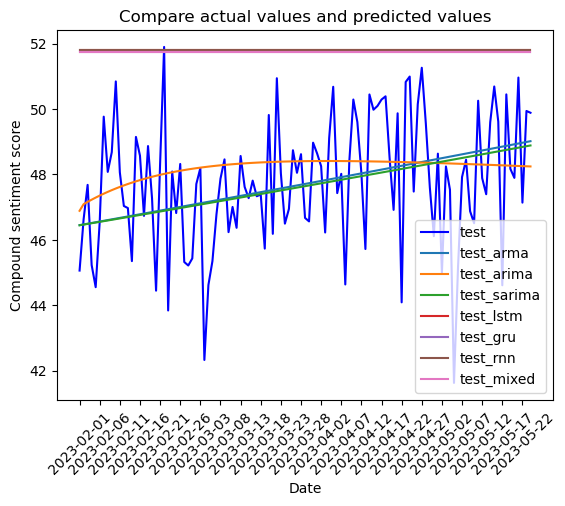

In [21]:
# Compare predictions for test dates
plt.plot(test, color='blue', label='test')
plt.plot(arma_pred, label='test_arma')
plt.plot(arima_pred, label='test_arima')
plt.plot(sarima_pred, label='test_sarima')
plt.plot(lstm_pred, label='test_lstm')
plt.plot(gru_pred, label='test_gru')
plt.plot(rnn_pred, label='test_rnn')
plt.plot(mixed_pred, label='test_mixed')
plt.ylabel('Compound sentiment score')
plt.xlabel('Date')
plt.xticks(list(test.index)[::5], rotation=45)
plt.legend()
plt.title('Compare actual values and predicted values')
plt.show()

### 4. Forecasting future

In [22]:
# create future date list
future_dates = []
future_timestamps = []
start_date = datetime.strptime(date_range[-1], '%Y-%m-%d')
for i in range(6*30):
    iter_date = start_date + timedelta(i+1)
    future_dates.append(iter_date.strftime("%Y-%m-%d"))
    future_timestamps.append([datetime.timestamp(iter_date)])
    
future_timestamps = np.array(future_timestamps)
print('Query will start from %s to %s' % (future_dates[0], future_dates[-1]))

Query will start from 2023-05-25 to 2023-11-20


In [23]:
def print_forecasts(ts_pred):
    global future_dates
    
    print('Next week (%s): %f' % (future_dates[6], ts_pred[6]))
    print('Next month (%s): %f' % (future_dates[29], ts_pred[29]))
    print('Next 3rdmonth (%s): %f' % (future_dates[89], ts_pred[89]))

In [24]:
# Train ARMA with full data
full_train = full.copy()
full_train.index = pd.DatetimeIndex(full_train.index.values).to_period('D')

# Create and train the Model
named_params = params_to_kwargs(best_arma_params)
arma_model = SARIMAX(full_train, **named_params).fit()

# Forecast
arma_pred_df = arma_model.get_forecast(len(future_timestamps)).conf_int(alpha=best_arma_params['conf_alpha'])
arma_pred = arma_model.predict(start=arma_pred_df.index[0], end=arma_pred_df.index[-1])
arma_pred.index = arma_pred_df.index
    
# Scale back to [-1, 1]
arma_pred = ts_unscale(arma_pred)

print('Autoregressive Moving Average (ARMA)')
print('------------------------------------------------')
print(best_arma_params)
print('------------------------------------------------')
print_forecasts(arma_pred)

Autoregressive Moving Average (ARMA)
------------------------------------------------
{'concentrate_scale': True, 'conf_alpha': 0.20396526654459302, 'enforce_invertibility': True, 'enforce_stationarity': False, 'hamilton_representation': True, 'measurement_error': True, 'mle_regression': False, 'order_0': 1, 'order_1': 0, 'order_2': 1, 'simple_differencing': True, 'time_varying_regression': True, 'trend': 't', 'use_exact_diffuse': False}
------------------------------------------------
Next week (2023-05-31): -0.010315
Next month (2023-06-23): 0.004327
Next 3rdmonth (2023-08-22): 0.042998


C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# Train ARIMA with full data
full_train = full.copy()
full_train.index = pd.DatetimeIndex(full_train.index.values).to_period('D')

# Create and train the Model
named_params = params_to_kwargs(best_arima_params)
arima_model = ARIMA(full_train, **named_params).fit()

# Forecast
arima_pred_df = arima_model.get_forecast(len(future_timestamps)).conf_int(alpha=best_arima_params['conf_alpha'])
arima_pred = arima_model.predict(start=arima_pred_df.index[0], end=arima_pred_df.index[-1])
arima_pred.index = arima_pred_df.index
    
# Scale back to [-1, 1]
arima_pred = ts_unscale(arima_pred)

print('Autoregressive Integrated Moving Average (ARIMA)')
print('------------------------------------------------')
print(best_arima_params)
print('------------------------------------------------')
print_forecasts(arima_pred)

Autoregressive Integrated Moving Average (ARIMA)
------------------------------------------------
{'concentrate_scale': False, 'conf_alpha': 0.7690228482008833, 'enforce_invertibility': False, 'enforce_stationarity': False, 'missing': 'drop', 'order_0': 1, 'order_1': 0, 'order_2': 2, 'trend': 'ct'}
------------------------------------------------
Next week (2023-05-31): -0.021574
Next month (2023-06-23): -0.014340
Next 3rdmonth (2023-08-22): -0.000707


In [26]:
# Train SARIMA with full data
full_train = full.copy()
full_train.index = pd.DatetimeIndex(full_train.index.values).to_period('D')

# Create and train the Model
named_params = params_to_kwargs(best_sarima_params)
sarima_model = SARIMAX(full_train, **named_params).fit()

# Forecast
sarima_pred_df = sarima_model.get_forecast(len(future_timestamps)).conf_int(alpha=best_sarima_params['conf_alpha'])
sarima_pred = sarima_model.predict(start=sarima_pred_df.index[0], end=sarima_pred_df.index[-1])
sarima_pred.index = sarima_pred_df.index
    
# Scale back to [-1, 1]
sarima_pred = ts_unscale(sarima_pred)

print('Seasonal ARIMA (SARIMA)')
print('------------------------------------------------')
print(best_sarima_params)
print('------------------------------------------------')
print_forecasts(sarima_pred)

Seasonal ARIMA (SARIMA)
------------------------------------------------
{'concentrate_scale': True, 'conf_alpha': 0.4081143078160746, 'enforce_invertibility': False, 'enforce_stationarity': True, 'hamilton_representation': True, 'measurement_error': True, 'mle_regression': True, 'order_0': 1, 'order_1': 0, 'order_2': 1, 'seasonal_0': 4, 'seasonal_1': 2, 'seasonal_2': 1, 'seasonal_3': 1, 'simple_differencing': False, 'time_varying_regression': False, 'trend': 't', 'use_exact_diffuse': False}
------------------------------------------------
Next week (2023-05-31): -0.010485
Next month (2023-06-23): 0.003758
Next 3rdmonth (2023-08-22): 0.041429


In [27]:
# Train LSTM with full data
full_train = full.copy()
full_train.index = pd.DatetimeIndex(full_train.index.values).to_period('D')

# Create and train the Model
lstm_model = create_model_builder('LSTM')(best_lstm_hps)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
lstm_model.fit(full_timestamps, full_train, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100
38/38 [==============================] - 1s 8ms/step - loss: 39.1091 - log_cosh: 38.2771 - mean_absolute_error: 38.9703 - mean_squared_error: 1576.2826 - binary_crossentropy: -750.1815
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 15.4681 - log_cosh: 14.3482 - mean_absolute_error: 15.0354 - mean_squared_error: 281.9485 - binary_crossentropy: -768.1434
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 3.5490 - log_cosh: 2.2220 - mean_absolute_error: 2.8232 - mean_squared_error: 12.9110 - binary_crossentropy: -768.1432
Epoch 4/100
38/38 [==============================] - 0s 6ms/step - loss: 3.2756 - log_cosh: 1.9999 - mean_absolute_error: 2.5945 - mean_squared_error: 10.9513 - binary_crossentropy: -768.1431
Epoch 5/100
38/38 [==============================] - 0s 6ms/step - loss: 3.2664 - log_cosh: 1.9876 - mean_absolute_error: 2.5763 - mean_squared_error: 10.9354 - binary_crossentropy: -768.1433
Epoch 6/100
38/38 [============

38/38 [==============================] - 0s 6ms/step - loss: 3.2910 - log_cosh: 2.0007 - mean_absolute_error: 2.5888 - mean_squared_error: 11.1084 - binary_crossentropy: -768.1431
Epoch 44/100
38/38 [==============================] - 0s 6ms/step - loss: 3.2567 - log_cosh: 1.9940 - mean_absolute_error: 2.5847 - mean_squared_error: 10.9757 - binary_crossentropy: -768.1434
Epoch 45/100
38/38 [==============================] - 0s 6ms/step - loss: 3.2816 - log_cosh: 2.0012 - mean_absolute_error: 2.5902 - mean_squared_error: 11.0307 - binary_crossentropy: -768.1433
Epoch 46/100
38/38 [==============================] - 0s 7ms/step - loss: 3.2495 - log_cosh: 1.9810 - mean_absolute_error: 2.5704 - mean_squared_error: 10.8470 - binary_crossentropy: -768.1432
Epoch 47/100
38/38 [==============================] - 0s 7ms/step - loss: 3.2447 - log_cosh: 1.9725 - mean_absolute_error: 2.5653 - mean_squared_error: 10.7581 - binary_crossentropy: -768.1430
Epoch 48/100
38/38 [============================

38/38 [==============================] - 0s 6ms/step - loss: 3.2796 - log_cosh: 2.0128 - mean_absolute_error: 2.6063 - mean_squared_error: 11.1068 - binary_crossentropy: -768.1432
Epoch 86/100
38/38 [==============================] - 0s 6ms/step - loss: 3.2646 - log_cosh: 1.9940 - mean_absolute_error: 2.5853 - mean_squared_error: 10.9299 - binary_crossentropy: -768.1432
Epoch 87/100
38/38 [==============================] - 0s 6ms/step - loss: 3.2557 - log_cosh: 1.9793 - mean_absolute_error: 2.5694 - mean_squared_error: 10.8243 - binary_crossentropy: -768.1431
Epoch 88/100
38/38 [==============================] - 0s 6ms/step - loss: 3.2922 - log_cosh: 2.0057 - mean_absolute_error: 2.5984 - mean_squared_error: 11.1034 - binary_crossentropy: -768.1432
Epoch 89/100
38/38 [==============================] - 0s 6ms/step - loss: 3.2850 - log_cosh: 2.0027 - mean_absolute_error: 2.5928 - mean_squared_error: 11.0164 - binary_crossentropy: -768.1432
Epoch 90/100
38/38 [============================

In [28]:
# LSTM continued

# Forecast
lstm_pred = lstm_model.predict(future_timestamps).flatten()
lstm_pred = pd.Series(lstm_pred, index=future_dates)
    
# Scale back to [-1, 1]
lstm_pred = ts_unscale(lstm_pred)

print('Neural Network with Long short-term memory (LSTM) layer')
print('------------------------------------------------')
lstm_model.summary()
print('------------------------------------------------')
print_forecasts(lstm_pred)

6/6 [==============================] - 0s 3ms/step
Neural Network with Long short-term memory (LSTM) layer
------------------------------------------------
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 240)            231360    
                                                                 
 dense_4 (Dense)             (None, 1, 1)              241       
                                                                 
Total params: 231,601
Trainable params: 231,601
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------
Next week (2023-05-31): 0.020617
Next month (2023-06-23): 0.020617
Next 3rdmonth (2023-08-22): 0.020617


In [29]:
# Skip GRU and RNN models, since they are also predicting a static value

In [30]:
# Train LSTM with full data
full_train = full.copy()
full_train.index = pd.DatetimeIndex(full_train.index.values).to_period('D')

# Create and train the Model
mixed_model = create_model_builder('mixed')(best_mixed_hps)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='min')
mixed_model.fit(full_timestamps, full_train, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100
38/38 [==============================] - 3s 10ms/step - loss: 46.9238 - log_cosh: 46.1199 - mean_absolute_error: 46.8131 - mean_squared_error: 2209.5217 - binary_crossentropy: -665.4393
Epoch 2/100
38/38 [==============================] - 0s 9ms/step - loss: 37.4551 - log_cosh: 36.6222 - mean_absolute_error: 37.3154 - mean_squared_error: 1409.4961 - binary_crossentropy: -768.1433
Epoch 3/100
38/38 [==============================] - 0s 9ms/step - loss: 28.0173 - log_cosh: 27.1344 - mean_absolute_error: 27.8276 - mean_squared_error: 792.6404 - binary_crossentropy: -768.1432
Epoch 4/100
38/38 [==============================] - 0s 9ms/step - loss: 18.6513 - log_cosh: 17.6736 - mean_absolute_error: 18.3668 - mean_squared_error: 355.2374 - binary_crossentropy: -768.1432
Epoch 5/100
38/38 [==============================] - 0s 9ms/step - loss: 9.6445 - log_cosh: 8.3839 - mean_absolute_error: 9.0673 - mean_squared_error: 99.2005 - binary_crossentropy: -768.1432
Epoch 6/100
38/38 [==

38/38 [==============================] - 0s 11ms/step - loss: 3.2557 - log_cosh: 1.9747 - mean_absolute_error: 2.5667 - mean_squared_error: 10.8230 - binary_crossentropy: -768.1431
Epoch 44/100
38/38 [==============================] - 0s 11ms/step - loss: 3.2579 - log_cosh: 1.9789 - mean_absolute_error: 2.5661 - mean_squared_error: 10.8300 - binary_crossentropy: -768.1432
Epoch 45/100
38/38 [==============================] - 0s 11ms/step - loss: 3.2565 - log_cosh: 1.9820 - mean_absolute_error: 2.5723 - mean_squared_error: 10.8646 - binary_crossentropy: -768.1433
Epoch 46/100
38/38 [==============================] - 0s 9ms/step - loss: 3.2620 - log_cosh: 1.9715 - mean_absolute_error: 2.5631 - mean_squared_error: 10.7986 - binary_crossentropy: -768.1433
Epoch 47/100
38/38 [==============================] - 0s 9ms/step - loss: 3.2456 - log_cosh: 1.9832 - mean_absolute_error: 2.5738 - mean_squared_error: 10.8182 - binary_crossentropy: -768.1431
Epoch 48/100
38/38 [=========================

38/38 [==============================] - 0s 9ms/step - loss: 3.2649 - log_cosh: 1.9732 - mean_absolute_error: 2.5630 - mean_squared_error: 10.8357 - binary_crossentropy: -768.1432
Epoch 86/100
38/38 [==============================] - 0s 9ms/step - loss: 3.2570 - log_cosh: 1.9813 - mean_absolute_error: 2.5741 - mean_squared_error: 10.8434 - binary_crossentropy: -768.1432
Epoch 87/100
38/38 [==============================] - 0s 9ms/step - loss: 3.2476 - log_cosh: 1.9775 - mean_absolute_error: 2.5682 - mean_squared_error: 10.8244 - binary_crossentropy: -768.1432
Epoch 88/100
38/38 [==============================] - 0s 9ms/step - loss: 3.2502 - log_cosh: 1.9739 - mean_absolute_error: 2.5638 - mean_squared_error: 10.7926 - binary_crossentropy: -768.1433
Epoch 89/100
38/38 [==============================] - 0s 9ms/step - loss: 3.2654 - log_cosh: 1.9807 - mean_absolute_error: 2.5733 - mean_squared_error: 10.8271 - binary_crossentropy: -768.1433
Epoch 90/100
38/38 [============================

In [31]:
# Mixed-RNN continued

# Forecast
mixed_pred = mixed_model.predict(future_timestamps).flatten()
mixed_pred = pd.Series(mixed_pred, index=future_dates)
    
# Scale back to [-1, 1]
mixed_pred = ts_unscale(mixed_pred)

print('Neural Network with mixed layers')
print('------------------------------------------------')
mixed_model.summary()
print('------------------------------------------------')
print_forecasts(mixed_pred)

6/6 [==============================] - 0s 3ms/step
Neural Network with mixed layers
------------------------------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 1, 160)            25760     
                                                                 
 gru_5 (GRU)                 (None, 1, 16)             8448      
                                                                 
 gru_6 (GRU)                 (None, 1, 320)            322560    
                                                                 
 dense_5 (Dense)             (None, 1, 1)              321       
                                                                 
Total params: 357,089
Trainable params: 357,089
Non-trainable params: 0
_________________________________________________________________
-----------------------------------------------

### 5. Visualize future forecast

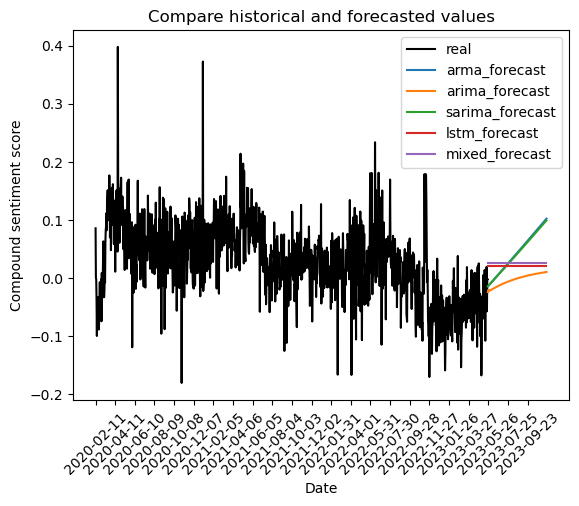

In [32]:
# Compare predictions for test dates
unscaled_full = ts_unscale(full)
plt.plot(unscaled_full, color='black', label='real')
arma_pred.index = future_dates
plt.plot(arma_pred, label='arma_forecast')
arima_pred.index = future_dates
plt.plot(arima_pred, label='arima_forecast')
sarima_pred.index = future_dates
plt.plot(sarima_pred, label='sarima_forecast')
plt.plot(lstm_pred, label='lstm_forecast')
plt.plot(mixed_pred, label='mixed_forecast')
plt.ylabel('Compound sentiment score')
plt.xlabel('Date')
all_indices = list(unscaled_full.index) + future_dates
plt.xticks(all_indices[::60], rotation=45)
plt.legend()
plt.title('Compare historical and forecasted values')
plt.show()